# GAN ODE Training

In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

from ode_training import GANODETrainer
from tqdm.notebook import tqdm

# from torchgan.losses import WassersteinDiscriminatorLoss, WassersteinGeneratorLoss

import random
# random.seed(0)
import numpy as np
# np.random.seed(0)

class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set batch size
bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

train_dataset = datasets.MNIST(root='../mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='../mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

# loss
criterion = nn.BCELoss() 
n_epoch = 100

# Adam

In [ ]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()
    
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
seed = 97382
print('seed',seed)
torch.manual_seed(seed)
# loss
criterion = nn.BCELoss() 
n_epoch = 100
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

D_losses_adam = []
G_losses_adam = []
# n_epoch = 20
for epoch in tqdm(range(1, n_epoch+1)):
    # D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        d_loss = D_train(x)
        g_loss = G_train(x)
        D_losses_adam.append(d_loss)
        G_losses_adam.append(g_loss)
    # print(d_loss,g_loss)

seed 97382


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


  0%|          | 0/100 [00:00<?, ?it/s]

0.9128695130348206 2.6874492168426514
0.7169766426086426 2.097168207168579
0.6711291074752808 4.07148551940918
0.391790509223938 2.6207311153411865
0.9480854272842407 2.3719286918640137
0.5651781558990479 2.55082631111145
0.9104161262512207 2.951016664505005
0.4243428409099579 2.162365198135376
0.4148382246494293 2.490788459777832
0.908238410949707 1.591103196144104
0.7890695333480835 1.8185980319976807
0.8766288757324219 2.8666625022888184
0.6368340253829956 1.9070243835449219
0.5525841116905212 2.269491195678711
0.6743085980415344 1.86040461063385
0.978544294834137 1.7966989278793335
0.9110383987426758 1.9435384273529053
0.7325636744499207 2.2464346885681152
0.7568520307540894 1.9788252115249634
0.8544864654541016 1.8582000732421875
1.0144612789154053 1.9603077173233032
1.1033592224121094 1.2836501598358154
0.8583896160125732 1.70500910282135
1.111626148223877 0.8965491056442261
0.8691478967666626 1.8037567138671875
0.8646062612533569 1.786869764328003
0.9301514625549316 1.1340811252

# ODE training

In [ ]:
def d_loss(x):
    # Discriminator
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output_real = D(x_real)
    D_real_loss = criterion(D_output_real, y_real)
    # D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output_fake = D(x_fake)
    D_fake_loss = criterion(D_output_fake, y_fake)
    # D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    # D_loss = dis_loss_fn(D_output_real,D_output_fake)
    return D_loss


def g_loss():
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)
    # G_loss = gen_loss_fn(D_output)
    return G_loss

## Euler

In [ ]:
# set seed
# seed = random.randint(0,100000)
seed = 97382
print('seed',seed)
torch.manual_seed(seed)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

method='euler'
ode_trainer = GANODETrainer(G.parameters(), D.parameters(), None, g_loss, d_loss, None,method=method)

d_iter = 3
g_iter = 1

d_losses_euler = []
g_losses_euler = []

for epoch in tqdm(range(1,n_epoch+1),desc='Training process'):
    i = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        disLoss = ode_trainer.step(x,model='dis_img')
        d_losses_euler.append(disLoss.item())
        i += 1
        if i < d_iter:
            continue
        else:
            i = 0
    
        genLoss = ode_trainer.step(model='gen')
        g_losses_euler.append(genLoss)
        
    if (epoch % 10) == 0:
        print(f'[EPOCH {epoch}/{n_epoch}] - Gen Loss {genLoss.item()} disLoss {disLoss.item()}')
        with torch.no_grad():
            test_z = torch.randn(bs,z_dim).to(device)
            generated = G(test_z)
            save_image(generated.view(generated.size(0), 1, 28, 28), f'../sample_{method}_{epoch}.png')

seed 97382
Choosing Euler method


Training process:   0%|          | 0/100 [00:00<?, ?it/s]

[EPOCH 10/100] - Gen Loss 1.7466487884521484 disLoss 0.327695369720459
[EPOCH 20/100] - Gen Loss 1.0605477094650269 disLoss 0.6815301775932312
[EPOCH 30/100] - Gen Loss 1.1919525861740112 disLoss 0.6455388069152832
[EPOCH 40/100] - Gen Loss 1.1811182498931885 disLoss 0.6139743328094482
[EPOCH 50/100] - Gen Loss 1.1696490049362183 disLoss 0.6228235363960266
[EPOCH 60/100] - Gen Loss 1.0879467725753784 disLoss 0.6402366161346436
[EPOCH 70/100] - Gen Loss 1.2354416847229004 disLoss 0.7047128677368164
[EPOCH 80/100] - Gen Loss 1.1383894681930542 disLoss 0.769896388053894
[EPOCH 90/100] - Gen Loss 1.0071111917495728 disLoss 0.7670120596885681
[EPOCH 100/100] - Gen Loss 1.0232332944869995 disLoss 0.7924907207489014


## RK2

In [ ]:
# set seed
seed = random.randint(0,100000)
# seed = 97382
print('seed',seed)
torch.manual_seed(seed)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

method='rk2'
ode_trainer = GANODETrainer(G.parameters(), D.parameters(), None, g_loss, d_loss, None,method=method)

d_iter = 3
g_iter = 1

d_losses_rk2 = []
g_losses_rk2 = []
d_iter=1

for epoch in tqdm(range(1,n_epoch+1),desc='Training process'):
    i = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        disLoss = ode_trainer.step(x,model='dis_img')
        d_losses_rk2.append(disLoss.item())
        i += 1
        if i < d_iter:
            continue
        else:
            i = 0
    
        genLoss = ode_trainer.step(model='gen')
        g_losses_rk2.append(genLoss)
        
    if (epoch % 10) == 0:
        print(f'[EPOCH {epoch}/{n_epoch}] - Gen Loss {genLoss.item()} disLoss {disLoss.item()}')
        with torch.no_grad():
            test_z = torch.randn(bs,z_dim).to(device)
            generated = G(test_z)
            save_image(generated.view(generated.size(0), 1, 28, 28), f'../sample_{method}_{epoch}.png')

seed 11481
Choosing Huen method


Training process:   0%|          | 0/100 [00:00<?, ?it/s]

[EPOCH 10/100] - Gen Loss 1.8404481410980225 disLoss 0.3153589367866516
[EPOCH 20/100] - Gen Loss 6.064634799957275 disLoss 0.008515914902091026
[EPOCH 30/100] - Gen Loss 8.534712791442871 disLoss 0.0005531794740818441
[EPOCH 40/100] - Gen Loss 7.8670268058776855 disLoss 0.0032744165509939194
[EPOCH 50/100] - Gen Loss 8.746740341186523 disLoss 0.00046001162263564765
[EPOCH 60/100] - Gen Loss 8.987287521362305 disLoss 0.0002900080580729991
[EPOCH 70/100] - Gen Loss 8.97633171081543 disLoss 0.00025509283295832574
[EPOCH 80/100] - Gen Loss 9.248726844787598 disLoss 0.0002493401989340782
[EPOCH 90/100] - Gen Loss 9.063848495483398 disLoss 0.00025971909053623676
[EPOCH 100/100] - Gen Loss 9.351337432861328 disLoss 0.0003247679560445249


## RK4

In [ ]:
# set seed
# seed = random.randint(0,100000)
seed = 97382
print('seed',seed)
torch.manual_seed(seed)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

method='rk4'
ode_trainer = GANODETrainer(G.parameters(), D.parameters(), None, g_loss, d_loss, None,method=method)

d_iter = 3
g_iter = 1

d_losses_rk4 = []
g_losses_rk4 = []
d_iter=1

for epoch in tqdm(range(1,n_epoch+1),desc='Training process'):
    i = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        disLoss = ode_trainer.step(x,model='dis_img')
        d_losses_rk4.append(disLoss.item())
        i += 1
        if i < d_iter:
            continue
        else:
            i = 0
    
        genLoss = ode_trainer.step(model='gen')
        g_losses_rk4.append(genLoss)
    print(f'[EPOCH {epoch}/{n_epoch}] - Gen Loss {genLoss.item()} disLoss {disLoss.item()}')
    if (epoch % 10) == 0:
        with torch.no_grad():
            test_z = torch.randn(bs,z_dim).to(device)
            generated = G(test_z)
            save_image(generated.view(generated.size(0), 1, 28, 28), f'../sample_{method}_{epoch}.png')

seed 97382
Choosing Runge-Kutta 4 method


Training process:   0%|          | 0/100 [00:00<?, ?it/s]

[EPOCH 1/100] - Gen Loss 1.1924751996994019 disLoss 0.6005796194076538
[EPOCH 2/100] - Gen Loss 1.8123688697814941 disLoss 0.345900297164917
[EPOCH 3/100] - Gen Loss 1.5307717323303223 disLoss 0.4055972099304199
[EPOCH 4/100] - Gen Loss 1.4422221183776855 disLoss 0.4984728693962097
[EPOCH 5/100] - Gen Loss 1.3022314310073853 disLoss 0.5606042146682739
[EPOCH 6/100] - Gen Loss 1.4211995601654053 disLoss 0.4667232036590576
[EPOCH 7/100] - Gen Loss 1.7111655473709106 disLoss 0.363511860370636
[EPOCH 8/100] - Gen Loss 2.116962194442749 disLoss 0.25863367319107056
[EPOCH 9/100] - Gen Loss 1.977561354637146 disLoss 0.2806086540222168
[EPOCH 10/100] - Gen Loss 1.6782249212265015 disLoss 0.4286675453186035
[EPOCH 11/100] - Gen Loss 2.08738374710083 disLoss 0.23089724779129028
[EPOCH 12/100] - Gen Loss 1.8107190132141113 disLoss 0.36776596307754517
[EPOCH 13/100] - Gen Loss 2.266622304916382 disLoss 0.24696767330169678
[EPOCH 14/100] - Gen Loss 1.4001210927963257 disLoss 0.47549307346343994
[EP

# Visualization

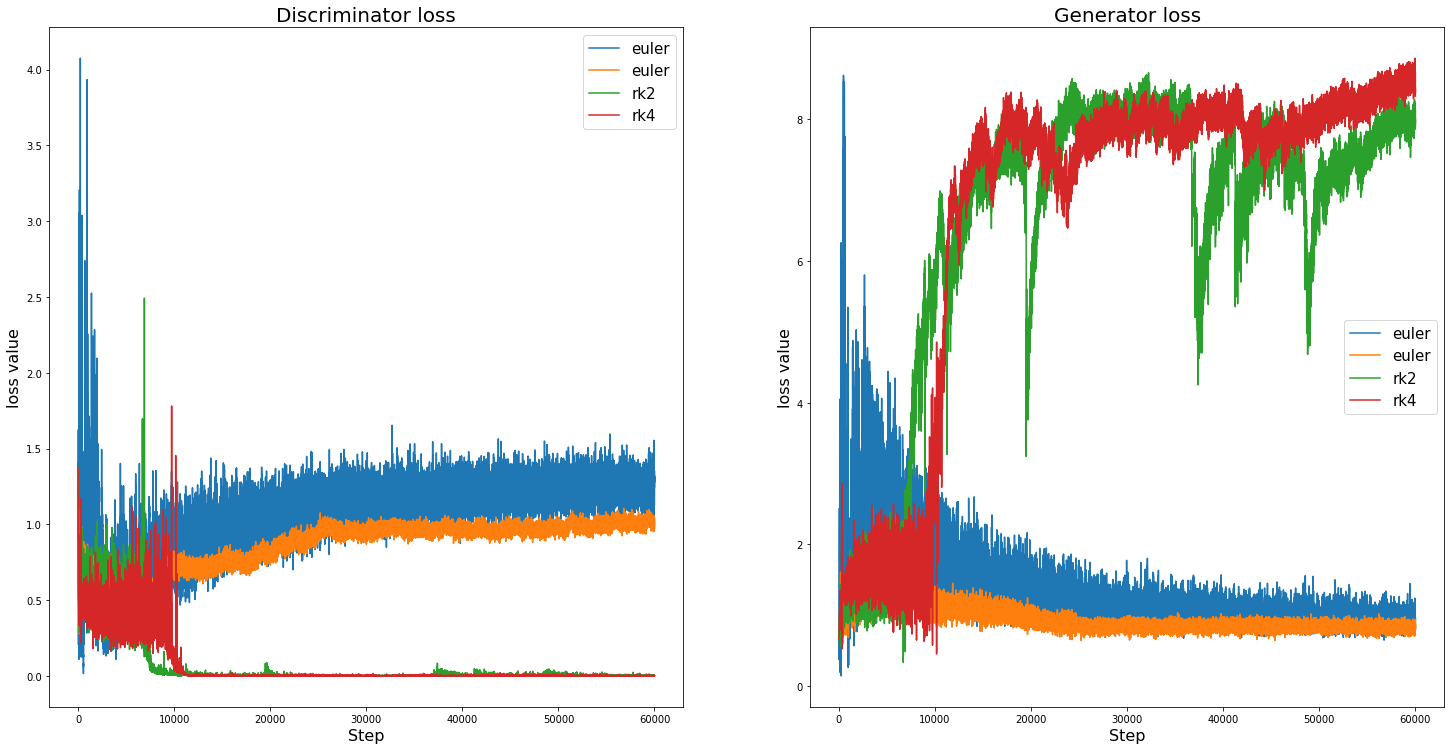

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,12.5))
plt.subplot(1,2,1)
plt.plot(D_losses_adam,label='euler')
plt.plot(d_losses_euler,label='euler')
plt.plot(d_losses_rk2,label='rk2')
plt.plot(d_losses_rk4,label='rk4')
plt.title('Discriminator loss',fontsize=20)
plt.xlabel('Step',fontsize=16)
plt.ylabel('loss value',fontsize=16)
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(G_losses_adam,label='euler')
plt.plot(g_losses_euler,label='euler')
plt.plot(g_losses_rk2,label='rk2')
plt.plot(g_losses_rk4,label='rk4')
plt.title('Generator loss',fontsize=20)
plt.xlabel('Step',fontsize=16)
plt.ylabel('loss value',fontsize=16)
plt.legend(fontsize=15)
plt.show()

In [ ]:
plt.figure(figsize=(25,12.5))
plt.subplot(1,2,1)
plt.plot(D_losses_adam,label='adam')
plt.plot(d_losses_euler,label='euler')
plt.plot(d_losses_rk2,label='rk2')
plt.plot(d_losses_rk4,label='rk4')
plt.title('Discriminator loss',fontsize=20)
plt.xlabel('Step',fontsize=16)
plt.ylabel('loss value',fontsize=16)
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(G_losses_adam,label='adam')
plt.plot(g_losses_euler,label='euler')
plt.plot(g_losses_rk2,label='rk2')
plt.plot(g_losses_rk4,label='rk4')
plt.title('Generator loss',fontsize=20)
plt.xlabel('Step',fontsize=16)
plt.ylabel('loss value',fontsize=16)
plt.legend(fontsize=15)
plt.show()